## Pandas analysis

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a couple of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every 'x' BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

TDC very fine, every tick is 25/30 nano seconds exactly, very precise; everything is like a clock, every cycle of 30 increments BX (like minuts for seconds); same goes for BX, between 0 and boh; after maximum ORBIT goes up... there are some conversions to be done, but roughly speaking is a clock: play vectorially with it!

In [2]:
# If you didn't download it yet, please get the relevant file now!
!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ~/data/

--2024-11-28 10:37:02--  https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.69.18, 2620:100:6025:18::a27d:4512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.69.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/pkkpoxlm7beasryexpdf8/data_000637.txt?rlkey=rkm2em1v57hewglzelmin21c9 [following]
--2024-11-28 10:37:03--  https://www.dropbox.com/scl/fi/pkkpoxlm7beasryexpdf8/data_000637.txt?rlkey=rkm2em1v57hewglzelmin21c9
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc4b9aac39f04dcce2f7d50f0d3e.dl.dropboxusercontent.com/cd/0/inline/CfPzs_Iw2T5GJnrq8lQHnMvMSPB7yHhYYCNlmBy97bdbJ5LBv_NYEwTLkMrUp6gjxfxu6aeE6siQ3RFVxPBubGLfec3MOrMuMzHyHK1j2QARqnvtV2Qj2XU1AUZlQx_C9xM/file# [following]
--2024-11-28 10:37:04--  https://uc4b9aac39f04dcce2f7d50f0d3e.dl.dropboxusercontent.com/cd/0/inline/CfPzs_Iw2T

1\. Create a Pandas DataFrame reading N rows of the 'data_000637.txt' dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k.

2\. Find out the number of BX in a ORBIT (the value 'x').

3\. Find out how much the data taking lasted. You can either make an estimate based on the fraction of the measurements (rows) you read, or perform this check precisely by reading out the whole dataset.

4\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information).

5\. Replace the values (all 1) of the HEAD column randomly with 0 or 1.

6\. Create a new DataFrame that contains only the rows with HEAD=1.

7\. Make two occupancy plots (one for each FPGA), i.e. plot the number of counts per TDC channel

8\. Use the groupby method to find out the noisy channels, i.e. the TDC channels with most counts (say the top 3)

9\. Count the number of unique orbits. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139

In [2]:
# -1 import things
import pandas as pd
import numpy as np
from numpy import random as npr
#import datetime as dt

In [3]:
# 0 find data file
data_file = !find ~/*/data_000637.txt
data_file = data_file[0]
print (data_file)

/home/leonardo-pieripoli/data/data_000637.txt


In [4]:
# 0.5 chose how much rows to read
# how many rows are there
total_rows = !grep -c -v "^#" $data_file
total_rows = int(total_rows[0])
min_rows = 10000
# how mutch rows to write
ROWS = npr.randint(min_rows, total_rows)
print(ROWS)

652792


In [5]:
# 1
data_frame = pd.read_csv(data_file, delimiter=',', nrows=ROWS)
data_frame

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25
...,...,...,...,...,...,...
652787,1,0,61,3869206653,3390,1
652788,1,0,51,3869206653,3389,5
652789,1,0,62,3869206653,3391,3
652790,1,0,51,3869206653,3403,3


In [6]:
# max values are 3563 for BX_COUNTER and 29 for TDC_MEAS;
# it is safe to assume a range [0; 3563] for BX_COUNTER, a total of 3564 cycles
BX_X = 3564
TDC_X = 30
TDC_ns = 25./30.
ORBIT_min = data_frame['ORBIT_CNT'][0]
data_frame.describe()

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
count,652792.0,652792.000000,652792.000000,6.527920e+05,652792.000000,652792.000000
mean,1.0,0.296051,55.902750,3.869203e+09,1790.912963,13.337120
std,0.0,0.456514,39.085724,1.909104e+03,1027.414799,9.207204
min,1.0,0.000000,1.000000,3.869200e+09,0.000000,0.000000
25%,1.0,0.000000,26.000000,3.869202e+09,905.000000,5.000000
50%,1.0,0.000000,57.000000,3.869203e+09,1795.000000,13.000000
75%,1.0,1.000000,64.000000,3.869205e+09,2683.000000,21.000000
max,1.0,1.000000,139.000000,3.869207e+09,3563.000000,29.000000


In [7]:
# 3
all_data = pd.read_csv(data_file, delimiter=',', nrows=(total_rows-1))
time_ns = ((all_data['ORBIT_CNT'].iloc[total_rows-2] - all_data['ORBIT_CNT'].iloc[0] )*BX_X*TDC_X + (all_data['BX_COUNTER'].iloc[total_rows-2] - all_data['BX_COUNTER'].iloc[0] )*TDC_X + (all_data['TDC_MEAS'].iloc[total_rows-2] - all_data['TDC_MEAS'].iloc[0] ))*TDC_ns
print( f"{total_rows-1} measures took: {time_ns:.0f} ns, or {time_ns//1000000000:.0f}s {(time_ns%1000000000)//1000000:.0f}ms {(time_ns%1000000)//1000:.0f}micros {(time_ns%1000):.0f}ns" )

1310720 measures took: 980416093 ns, or 0s 980ms 416micros 93ns


In [8]:
# 4
time_offset = data_frame['ORBIT_CNT'].iloc[0]*BX_X*TDC_X + data_frame['BX_COUNTER'].iloc[0]*TDC_X + data_frame['TDC_MEAS'].iloc[0]
data_frame['TIME_NS'] = pd.Series((((data_frame['ORBIT_CNT']*BX_X*TDC_X + data_frame['BX_COUNTER']*TDC_X + data_frame['TDC_MEAS']) - time_offset) * TDC_ns ), index=data_frame.index)
data_frame

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME_NS
0,1,0,123,3869200167,2374,26,0.000000e+00
1,1,0,124,3869200167,2374,27,8.333333e-01
2,1,0,63,3869200167,2553,28,4.476667e+03
3,1,0,64,3869200167,2558,19,4.594167e+03
4,1,0,64,3869200167,2760,25,9.649167e+03
...,...,...,...,...,...,...,...
652787,1,0,61,3869206653,3390,1,5.779280e+08
652788,1,0,51,3869206653,3389,5,5.779280e+08
652789,1,0,62,3869206653,3391,3,5.779280e+08
652790,1,0,51,3869206653,3403,3,5.779283e+08


In [9]:
# 4 control
#time_offset = all_data['ORBIT_CNT'].iloc[0]*BX_X*TDC_X + all_data['BX_COUNTER'].iloc[0]*TDC_X + all_data['TDC_MEAS'].iloc[0]
all_data['TIME_NS'] = pd.Series((((all_data['ORBIT_CNT']*BX_X*TDC_X + all_data['BX_COUNTER']*TDC_X + all_data['TDC_MEAS']) - time_offset) * TDC_ns ), index=all_data.index)
all_data

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME_NS
0,1,0,123,3869200167,2374,26,0.000000e+00
1,1,0,124,3869200167,2374,27,8.333333e-01
2,1,0,63,3869200167,2553,28,4.476667e+03
3,1,0,64,3869200167,2558,19,4.594167e+03
4,1,0,64,3869200167,2760,25,9.649167e+03
...,...,...,...,...,...,...,...
1310715,1,0,62,3869211171,762,14,9.804161e+08
1310716,1,1,4,3869211171,763,11,9.804161e+08
1310717,1,0,64,3869211171,764,0,9.804161e+08
1310718,1,0,139,3869211171,769,0,9.804163e+08


In [10]:
data_frame['HEAD'] = pd.Series(npr.randint(0,2,ROWS), index=data_frame.index)
data_frame

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME_NS
0,1,0,123,3869200167,2374,26,0.000000e+00
1,1,0,124,3869200167,2374,27,8.333333e-01
2,1,0,63,3869200167,2553,28,4.476667e+03
3,0,0,64,3869200167,2558,19,4.594167e+03
4,0,0,64,3869200167,2760,25,9.649167e+03
...,...,...,...,...,...,...,...
652787,0,0,61,3869206653,3390,1,5.779280e+08
652788,1,0,51,3869206653,3389,5,5.779280e+08
652789,1,0,62,3869206653,3391,3,5.779280e+08
652790,0,0,51,3869206653,3403,3,5.779283e+08


In [11]:
data_chosen = data_frame[data_frame['HEAD'] > 0]
data_chosen

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME_NS
0,1,0,123,3869200167,2374,26,0.000000e+00
1,1,0,124,3869200167,2374,27,8.333333e-01
2,1,0,63,3869200167,2553,28,4.476667e+03
6,1,0,61,3869200167,2772,14,9.940000e+03
7,1,0,139,3869200167,2776,0,1.002833e+04
...,...,...,...,...,...,...,...
652785,1,0,50,3869206653,3389,27,5.779280e+08
652786,1,0,139,3869206653,3401,0,5.779283e+08
652788,1,0,51,3869206653,3389,5,5.779280e+08
652789,1,0,62,3869206653,3391,3,5.779280e+08


Text(0, 0.5, 'counts')

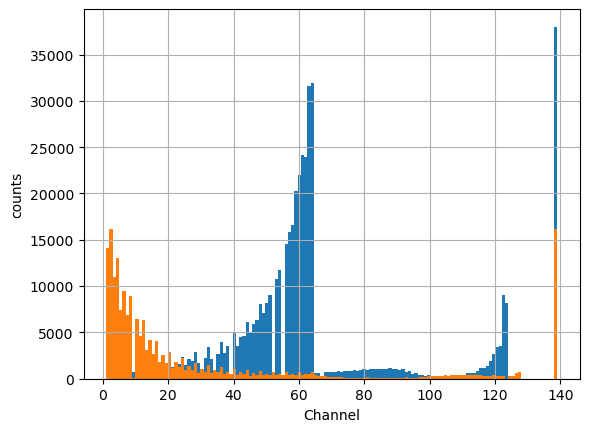

In [15]:
import matplotlib.pyplot as plt
plt.figure()
data_frame['TDC_CHANNEL'][data_frame['FPGA'] == 0].hist(bins = data_frame['TDC_CHANNEL'].max())
data_frame['TDC_CHANNEL'][data_frame['FPGA']>0].hist(bins = data_frame['TDC_CHANNEL'].max())
plt.xlabel('Channel'); plt.ylabel('counts')

In [27]:
g_data_f0 = data_frame[data_frame['FPGA'] == 0].groupby('TDC_CHANNEL').sum()
g_data_f1 = data_frame[data_frame['FPGA'] == 1].groupby('TDC_CHANNEL').sum()
g_data_f0_M1 = g_data_f0['HEAD'].idxmax()
g_data_f0_M2 = g_data_f0['HEAD'][~g_data_f0.index.isin([g_data_f0_M1])].idxmax()
g_data_f0_M3 = g_data_f0['HEAD'][~g_data_f0.index.isin([g_data_f0_M1, g_data_f0_M2])].idxmax()
print( f'FPGA 0: 3 most noisy channel (ordered) = {g_data_f0_M1:.0f}; {g_data_f0_M2:.0f}; {g_data_f0_M3:.0f}')
g_data_f1_M1 = g_data_f1['HEAD'].idxmax()
g_data_f1_M2 = g_data_f1['HEAD'][~g_data_f1.index.isin([g_data_f1_M1])].idxmax()
g_data_f1_M3 = g_data_f1['HEAD'][~g_data_f1.index.isin([g_data_f1_M1, g_data_f1_M2])].idxmax()
print( f'FPGA 1: 3 most noisy channel (ordered) = {g_data_f1_M1:.0f}; {g_data_f1_M2:.0f}; {g_data_f1_M3:.0f}')

FPGA 0: 3 most noisy channel (ordered) = 139; 64; 63
FPGA 1: 3 most noisy channel (ordered) = 139; 2; 1


In [51]:
# 9. Count the number of unique orbits. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139
orbit_counter = all_data.groupby('ORBIT_CNT').size()
print(orbit_counter)
unique_oc= len(orbit_counter[orbit_counter == 1 ])
#print(unique_oc)

#orbit_counter_139 = all_data[all_data['ORBIT_CNT']].groupby('ORBIT_CNT').size()
#print(orbit_counter)
#unique_oc= len(orbit_counter[orbit_counter == 1 ])
#print()
#print(unique_oc)

ORBIT_CNT
3869200167     43
3869200168     85
3869200169    127
3869200170     98
3869200171    109
             ... 
3869211167    208
3869211168    109
3869211169    191
3869211170    137
3869211171     22
Length: 11001, dtype: int64
